In [47]:
import pandas as pd
from backtesting import Backtest, Strategy
import backtesting
from backtesting.lib import crossover

backtesting.set_bokeh_output(notebook=True)

In [48]:
data = pd.read_csv('SPY_2024_15min.CSV')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data

,Open,Low,High,Close,Volume
date,,,,,
2020-01-02 09:30:00,323.54,323.4100,324.00,323.870,3583238
2020-01-02 09:45:00,323.87,323.5700,324.03,323.870,2908107
2020-01-02 10:00:00,323.87,323.0900,323.90,323.120,1810195
2020-01-02 10:15:00,323.12,322.6100,323.12,323.020,2996731
2020-01-02 10:30:00,323.01,322.6681,323.04,322.905,1063232
...,...,...,...,...,...
2024-12-31 14:45:00,585.08,584.8700,586.34,586.330,1399535
2024-12-31 15:00:00,586.31,585.1700,586.83,585.390,1728789
2024-12-31 15:15:00,585.39,585.1900,587.30,587.230,1869350


In [49]:
def EMA(prices, period):
    return pd.Series(prices).ewm(span=period, adjust=False).mean()

In [50]:
data['EMA_50'] = EMA(data['Close'], 50)
data['EMA_200'] = EMA(data['Close'], 200)

<Axes: xlabel='date'>

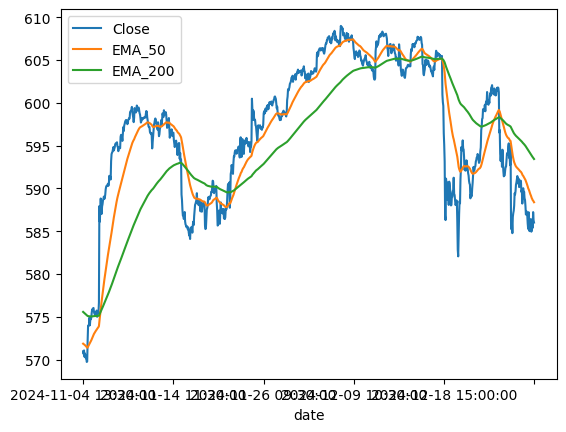

In [51]:
plot_data = data.copy()
plot_data.index = pd.Series(plot_data.index).apply(str)
plot_data.tail(1000)[['Close', 'EMA_50', 'EMA_200']].plot()

In [54]:
class EMACross(Strategy):
    fast_period = 50
    slow_period = 200
    tp = 0.1
    sl = 0.05
    
    def init(self):
        close = self.data.Close
        self.ema_fast = self.I(EMA, close, self.fast_period)
        self.ema_slow = self.I(EMA, close, self.slow_period)
        
    def next(self):
        current_price = self.data.Close[-1]
        
        if crossover(self.ema_fast, self.ema_slow):
            self.buy(tp=current_price * (1 + self.tp), sl=current_price * (1 - self.sl))
        elif crossover(self.ema_slow, self.ema_fast):
            self.sell(tp=current_price * (1 - self.tp), sl=current_price * (1 + self.sl))

In [56]:
bt = Backtest(data, EMACross, cash=10_000, commission=.002, exclusive_orders=True)

In [57]:
stats = bt.optimize(
    fast_period=[5, 10, 25, 50, 75, 100],
    slow_period=[50, 75, 100, 150, 200, 500],
    tp=[0.01, 0.025, 0.05, 0.1, 0.2, 0.25],
    sl=[0.01, 0.025, 0.05, 0.1, 0.2, 0.25],
    constraint=lambda p: p.tp > p.sl,
    max_tries=20,
    random_state=5
)

  0%|          | 0/11 [00:00<?, ?it/s]

In [58]:
stats

Start                     2020-01-02 09:30:00
End                       2024-12-31 15:45:00
Duration                   1825 days 06:15:00
Exposure Time [%]                   99.048159
Equity Final [$]                 12760.902554
Equity Peak [$]                  15971.635279
Return [%]                          27.609026
Buy & Hold Return [%]               80.939883
Return (Ann.) [%]                    5.015223
Volatility (Ann.) [%]               18.810807
Sharpe Ratio                         0.266614
Sortino Ratio                        0.414322
Calmar Ratio                         0.158149
Max. Drawdown [%]                   -31.71194
Avg. Drawdown [%]                   -0.990493
Max. Drawdown Duration     1581 days 00:15:00
Avg. Drawdown Duration       14 days 02:34:00
# Trades                                  260
Win Rate [%]                        22.692308
Best Trade [%]                       25.70606
Worst Trade [%]                     -3.022141
Avg. Trade [%]                    

In [59]:
bt.plot()

GridPlot(id='p1316', ...)